# start

from 0320_3; 5e6 data

In [1]:
PRFX='0320_4'
trntmstmp=1584412344
valtmstmp=1584806233
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])

params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss'],
    'max_delta_step': 1,
}
num_rounds = 800

['2020-03-17 02:32:24', '2020-03-21 15:57:13']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
# langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

#     for lang in langs:
#         df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total

150000000.0

In [6]:
grand_total/1e6

150.0

In [7]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=4: break



2020-03-20 18:30:14 chunk 0
2020-03-20 18:30:29 chunk 1
2020-03-20 18:30:44 chunk 2
2020-03-20 18:30:59 chunk 3
2020-03-20 18:31:15 chunk 4


In [8]:
df = pd.concat(lst_df)

In [9]:
df.shape

(5000000, 29)

In [10]:
df.columns

Index(['u1_fllwer_cnt', 'u1_fllwng_cnt', 'u1_vrfed', 'u2_fllwer_cnt',
       'u2_fllwng_cnt', 'u2_vrfed', 'u1_fllw_u2', 'len_toks',
       'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs',
       'num_links', 'num_domns', 'twt_age', 'u1_age', 'u2_age', 'tm_dayofweek',
       'tm_hour', 'tmdlta_u2u1', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'twttyp_TopLevel', 'twttyp_Retweet',
       'twttyp_Quote', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

In [11]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [12]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 656 ms, sys: 1.29 s, total: 1.94 s
Wall time: 1.95 s


In [13]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((4250000, 25), (750000, 25), (4250000, 4), (750000, 4))

# model

In [14]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-20 18:33:51 Retweet ********************************************************************************
[18:34:06] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[18:34:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.11288	train-logloss:0.58738	eval-error:0.11360	eval-logloss:0.58862
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[18:34:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.11287	train-logloss:0.50544	eval-error:0.11360	eval-logloss:0.50575
[18:34:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max

[18:37:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[38]	train-error:0.11225	train-logloss:0.32155	eval-error:0.11303	eval-logloss:0.32414
[18:37:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.11223	train-logloss:0.32148	eval-error:0.11302	eval-logloss:0.32408
[18:37:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.11223	train-logloss:0.32137	eval-error:0.11300	eval-logloss:0.32400
[18:37:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.11221	train-logloss:0.32130	eval-error:0.11301	eval-logloss:0.32396
[18:37:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-error:0.11221	train-logloss:0.32118	

[18:40:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[78]	train-error:0.11188	train-logloss:0.31847	eval-error:0.11291	eval-logloss:0.32195
[18:40:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[79]	train-error:0.11188	train-logloss:0.31841	eval-error:0.11291	eval-logloss:0.32189
[18:40:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-error:0.11188	train-logloss:0.31835	eval-error:0.11289	eval-logloss:0.32185
[18:40:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.11187	train-logloss:0.31827	eval-error:0.11284	eval-logloss:0.32179
[18:40:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[82]	train-error:0.11186	train-logloss:0.31823	

[18:43:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[118]	train-error:0.11161	train-logloss:0.31664	eval-error:0.11268	eval-logloss:0.32091
[18:43:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[119]	train-error:0.11160	train-logloss:0.31661	eval-error:0.11269	eval-logloss:0.32090
[18:43:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[120]	train-error:0.11160	train-logloss:0.31656	eval-error:0.11269	eval-logloss:0.32087
[18:43:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[121]	train-error:0.11159	train-logloss:0.31652	eval-error:0.11267	eval-logloss:0.32084
[18:44:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[122]	train-error:0.11158	train-logloss:0.3

[18:46:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[158]	train-error:0.11134	train-logloss:0.31508	eval-error:0.11254	eval-logloss:0.32012
[18:46:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[159]	train-error:0.11134	train-logloss:0.31505	eval-error:0.11255	eval-logloss:0.32012
[18:47:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[160]	train-error:0.11134	train-logloss:0.31503	eval-error:0.11255	eval-logloss:0.32012
[18:47:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[161]	train-error:0.11133	train-logloss:0.31497	eval-error:0.11255	eval-logloss:0.32008
[18:47:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[162]	train-error:0.11132	train-logloss:0.3

[18:50:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[198]	train-error:0.11115	train-logloss:0.31388	eval-error:0.11250	eval-logloss:0.31975
[18:50:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[199]	train-error:0.11115	train-logloss:0.31385	eval-error:0.11250	eval-logloss:0.31973
[18:50:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[200]	train-error:0.11115	train-logloss:0.31381	eval-error:0.11250	eval-logloss:0.31973
[18:50:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[201]	train-error:0.11114	train-logloss:0.31378	eval-error:0.11252	eval-logloss:0.31971
[18:50:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[202]	train-error:0.11113	train-logloss:0.3

[18:53:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[238]	train-error:0.11097	train-logloss:0.31275	eval-error:0.11245	eval-logloss:0.31937
[18:53:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[239]	train-error:0.11096	train-logloss:0.31273	eval-error:0.11246	eval-logloss:0.31936
[18:53:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[240]	train-error:0.11096	train-logloss:0.31270	eval-error:0.11245	eval-logloss:0.31934
[18:54:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[241]	train-error:0.11095	train-logloss:0.31266	eval-error:0.11245	eval-logloss:0.31933
[18:54:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[242]	train-error:0.11095	train-logloss:0.31

[277]	train-error:0.11075	train-logloss:0.31170	eval-error:0.11243	eval-logloss:0.31911
[18:57:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[278]	train-error:0.11075	train-logloss:0.31167	eval-error:0.11244	eval-logloss:0.31911
[18:57:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[279]	train-error:0.11074	train-logloss:0.31164	eval-error:0.11242	eval-logloss:0.31910
[18:57:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[280]	train-error:0.11074	train-logloss:0.31162	eval-error:0.11243	eval-logloss:0.31910
[18:57:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[281]	train-error:0.11073	train-logloss:0.31160	eval-error:0.11242	eval-logloss:0.31910
[18:57:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[19:00:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[317]	train-error:0.11058	train-logloss:0.31077	eval-error:0.11230	eval-logloss:0.31896
[19:00:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[318]	train-error:0.11058	train-logloss:0.31075	eval-error:0.11231	eval-logloss:0.31895
[19:00:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[319]	train-error:0.11058	train-logloss:0.31073	eval-error:0.11232	eval-logloss:0.31895
[19:00:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[320]	train-error:0.11058	train-logloss:0.31070	eval-error:0.11231	eval-logloss:0.31894
[19:00:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[321]	train-error:0.11058	train-logloss:0.3

[19:03:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-error:0.02747	train-logloss:0.17522	eval-error:0.02758	eval-logloss:0.17537
[19:03:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-error:0.02747	train-logloss:0.15481	eval-error:0.02758	eval-logloss:0.15536
[19:03:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-error:0.02747	train-logloss:0.14117	eval-error:0.02758	eval-logloss:0.14155
[19:04:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-error:0.02747	train-logloss:0.13181	eval-error:0.02758	eval-logloss:0.13221
[19:04:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-error:0.02747	train-logloss:0.12557	eval

[19:07:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[46]	train-error:0.02747	train-logloss:0.11217	eval-error:0.02758	eval-logloss:0.11341
[19:07:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[47]	train-error:0.02747	train-logloss:0.11215	eval-error:0.02758	eval-logloss:0.11341
[19:07:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[48]	train-error:0.02747	train-logloss:0.11212	eval-error:0.02758	eval-logloss:0.11340
[19:07:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[49]	train-error:0.02747	train-logloss:0.11211	eval-error:0.02758	eval-logloss:0.11340
[19:07:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[50]	train-error:0.02747	train-logloss:0.11207	e

[85]	train-error:0.02747	train-logloss:0.11127	eval-error:0.02759	eval-logloss:0.11324
[19:10:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[86]	train-error:0.02747	train-logloss:0.11123	eval-error:0.02759	eval-logloss:0.11323
[19:10:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[87]	train-error:0.02747	train-logloss:0.11120	eval-error:0.02759	eval-logloss:0.11322
[19:10:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[88]	train-error:0.02747	train-logloss:0.11118	eval-error:0.02759	eval-logloss:0.11322
[19:10:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[89]	train-error:0.02747	train-logloss:0.11115	eval-error:0.02759	eval-logloss:0.11322
[19:11:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 e

[19:14:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[16]	train-error:0.33174	train-logloss:0.60995	eval-error:0.33232	eval-logloss:0.61046
[19:14:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[17]	train-error:0.33135	train-logloss:0.60950	eval-error:0.33187	eval-logloss:0.61002
[19:14:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[18]	train-error:0.33101	train-logloss:0.60903	eval-error:0.33171	eval-logloss:0.60953
[19:14:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[19]	train-error:0.33078	train-logloss:0.60875	eval-error:0.33145	eval-logloss:0.60926
[19:14:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[20]	train-error:0.33040	train-logloss:0.60839	

[19:17:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[56]	train-error:0.32341	train-logloss:0.60088	eval-error:0.32480	eval-logloss:0.60218
[19:17:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[57]	train-error:0.32323	train-logloss:0.60073	eval-error:0.32455	eval-logloss:0.60204
[19:17:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[58]	train-error:0.32323	train-logloss:0.60070	eval-error:0.32451	eval-logloss:0.60203
[19:17:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[59]	train-error:0.32311	train-logloss:0.60056	eval-error:0.32447	eval-logloss:0.60192
[19:18:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[60]	train-error:0.32305	train-logloss:0.60049	

[95]	train-error:0.32049	train-logloss:0.59744	eval-error:0.32198	eval-logloss:0.59944
[19:21:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[96]	train-error:0.32044	train-logloss:0.59740	eval-error:0.32195	eval-logloss:0.59940
[19:21:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[97]	train-error:0.32042	train-logloss:0.59736	eval-error:0.32200	eval-logloss:0.59939
[19:21:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[98]	train-error:0.32038	train-logloss:0.59731	eval-error:0.32199	eval-logloss:0.59936
[19:21:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[99]	train-error:0.32029	train-logloss:0.59719	eval-error:0.32190	eval-logloss:0.59927
[19:21:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 ex

[19:24:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[135]	train-error:0.31832	train-logloss:0.59491	eval-error:0.32054	eval-logloss:0.59758
[19:24:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[136]	train-error:0.31824	train-logloss:0.59480	eval-error:0.32045	eval-logloss:0.59749
[19:24:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[137]	train-error:0.31813	train-logloss:0.59468	eval-error:0.32031	eval-logloss:0.59737
[19:24:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[138]	train-error:0.31798	train-logloss:0.59450	eval-error:0.32017	eval-logloss:0.59720
[19:24:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[139]	train-error:0.31792	train-logloss:0.5

[174]	train-error:0.31658	train-logloss:0.59286	eval-error:0.31947	eval-logloss:0.59623
[19:28:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[175]	train-error:0.31654	train-logloss:0.59282	eval-error:0.31953	eval-logloss:0.59621
[19:28:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[176]	train-error:0.31650	train-logloss:0.59276	eval-error:0.31947	eval-logloss:0.59616
[19:28:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[177]	train-error:0.31647	train-logloss:0.59269	eval-error:0.31943	eval-logloss:0.59610
[19:28:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[178]	train-error:0.31645	train-logloss:0.59265	eval-error:0.31934	eval-logloss:0.59608
[19:28:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 

[19:31:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[214]	train-error:0.31496	train-logloss:0.59095	eval-error:0.31828	eval-logloss:0.59506
[19:31:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[215]	train-error:0.31493	train-logloss:0.59090	eval-error:0.31825	eval-logloss:0.59503
[19:31:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[216]	train-error:0.31488	train-logloss:0.59085	eval-error:0.31822	eval-logloss:0.59500
[19:31:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[217]	train-error:0.31484	train-logloss:0.59079	eval-error:0.31817	eval-logloss:0.59495
[19:31:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[218]	train-error:0.31479	train-logloss:0.5

[19:35:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[254]	train-error:0.31374	train-logloss:0.58939	eval-error:0.31769	eval-logloss:0.59415
[19:35:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[255]	train-error:0.31373	train-logloss:0.58937	eval-error:0.31766	eval-logloss:0.59414
[19:35:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[256]	train-error:0.31368	train-logloss:0.58931	eval-error:0.31762	eval-logloss:0.59410
[19:35:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[257]	train-error:0.31364	train-logloss:0.58929	eval-error:0.31762	eval-logloss:0.59410
[19:35:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[258]	train-error:0.31362	train-logloss:0.589

[19:38:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[294]	train-error:0.31244	train-logloss:0.58779	eval-error:0.31695	eval-logloss:0.59312
[19:38:38] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[295]	train-error:0.31243	train-logloss:0.58776	eval-error:0.31694	eval-logloss:0.59311
[19:38:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[296]	train-error:0.31239	train-logloss:0.58770	eval-error:0.31692	eval-logloss:0.59307
[19:38:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[297]	train-error:0.31237	train-logloss:0.58765	eval-error:0.31693	eval-logloss:0.59304
[19:38:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[298]	train-error:0.31237	train-logloss:0.5

[19:41:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[334]	train-error:0.31151	train-logloss:0.58661	eval-error:0.31652	eval-logloss:0.59265
[19:41:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[335]	train-error:0.31149	train-logloss:0.58658	eval-error:0.31647	eval-logloss:0.59265
[19:42:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[336]	train-error:0.31147	train-logloss:0.58656	eval-error:0.31647	eval-logloss:0.59264
[19:42:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[337]	train-error:0.31146	train-logloss:0.58652	eval-error:0.31646	eval-logloss:0.59262
[19:42:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[338]	train-error:0.31143	train-logloss:0.58

[19:45:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[374]	train-error:0.31061	train-logloss:0.58548	eval-error:0.31623	eval-logloss:0.59210
[19:45:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[375]	train-error:0.31057	train-logloss:0.58544	eval-error:0.31619	eval-logloss:0.59208
[19:45:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[376]	train-error:0.31055	train-logloss:0.58541	eval-error:0.31618	eval-logloss:0.59207
[19:45:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[377]	train-error:0.31055	train-logloss:0.58539	eval-error:0.31620	eval-logloss:0.59206
[19:45:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[378]	train-error:0.31051	train-logloss:0.58

[19:48:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[414]	train-error:0.30971	train-logloss:0.58440	eval-error:0.31560	eval-logloss:0.59169
[19:48:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[415]	train-error:0.30971	train-logloss:0.58438	eval-error:0.31556	eval-logloss:0.59167
[19:48:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[416]	train-error:0.30967	train-logloss:0.58434	eval-error:0.31560	eval-logloss:0.59165
[19:48:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[417]	train-error:0.30964	train-logloss:0.58431	eval-error:0.31556	eval-logloss:0.59164
[19:48:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[418]	train-error:0.30960	train-logloss:0.58

[453]	train-error:0.30880	train-logloss:0.58321	eval-error:0.31516	eval-logloss:0.59107
[19:51:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[454]	train-error:0.30878	train-logloss:0.58318	eval-error:0.31513	eval-logloss:0.59107
[19:51:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[455]	train-error:0.30875	train-logloss:0.58315	eval-error:0.31512	eval-logloss:0.59105
[19:52:04] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[456]	train-error:0.30874	train-logloss:0.58313	eval-error:0.31512	eval-logloss:0.59105
[19:52:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[457]	train-error:0.30873	train-logloss:0.58313	eval-error:0.31512	eval-logloss:0.59105
[19:52:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 1

[19:55:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[493]	train-error:0.30788	train-logloss:0.58209	eval-error:0.31457	eval-logloss:0.59062
[19:55:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[494]	train-error:0.30787	train-logloss:0.58207	eval-error:0.31461	eval-logloss:0.59062
[19:55:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[495]	train-error:0.30787	train-logloss:0.58205	eval-error:0.31461	eval-logloss:0.59062
[19:55:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[496]	train-error:0.30785	train-logloss:0.58203	eval-error:0.31465	eval-logloss:0.59062
[19:55:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[497]	train-error:0.30782	train-logloss:0.5

[19:58:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[533]	train-error:0.30719	train-logloss:0.58123	eval-error:0.31452	eval-logloss:0.59046
[19:58:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[534]	train-error:0.30718	train-logloss:0.58120	eval-error:0.31447	eval-logloss:0.59045
[19:58:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[535]	train-error:0.30717	train-logloss:0.58119	eval-error:0.31446	eval-logloss:0.59044
[19:58:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[536]	train-error:0.30718	train-logloss:0.58117	eval-error:0.31450	eval-logloss:0.59044
[19:58:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[537]	train-error:0.30717	train-logloss:0.5811

[20:01:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[573]	train-error:0.30644	train-logloss:0.58036	eval-error:0.31422	eval-logloss:0.59023
[20:01:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[574]	train-error:0.30640	train-logloss:0.58031	eval-error:0.31417	eval-logloss:0.59020
[20:01:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[575]	train-error:0.30639	train-logloss:0.58028	eval-error:0.31417	eval-logloss:0.59018
[20:02:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[576]	train-error:0.30636	train-logloss:0.58025	eval-error:0.31418	eval-logloss:0.59018
[20:02:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[577]	train-error:0.30635	train-logloss:0.5

[20:05:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[613]	train-error:0.30559	train-logloss:0.57925	eval-error:0.31375	eval-logloss:0.58977
[20:05:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[614]	train-error:0.30555	train-logloss:0.57920	eval-error:0.31374	eval-logloss:0.58974
[20:05:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[615]	train-error:0.30551	train-logloss:0.57917	eval-error:0.31376	eval-logloss:0.58973
[20:05:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[616]	train-error:0.30550	train-logloss:0.57915	eval-error:0.31375	eval-logloss:0.58972
[20:05:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[617]	train-error:0.30549	train-logloss:0.5

[20:08:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[653]	train-error:0.30490	train-logloss:0.57834	eval-error:0.31358	eval-logloss:0.58943
[20:08:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[654]	train-error:0.30489	train-logloss:0.57831	eval-error:0.31356	eval-logloss:0.58942
[20:08:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[655]	train-error:0.30486	train-logloss:0.57829	eval-error:0.31355	eval-logloss:0.58941
[20:08:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[656]	train-error:0.30487	train-logloss:0.57827	eval-error:0.31352	eval-logloss:0.58941
[20:08:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[657]	train-error:0.30486	train-logloss:0.57

[20:11:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[693]	train-error:0.30413	train-logloss:0.57743	eval-error:0.31322	eval-logloss:0.58921
[20:11:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[694]	train-error:0.30412	train-logloss:0.57741	eval-error:0.31322	eval-logloss:0.58920
[20:11:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[695]	train-error:0.30409	train-logloss:0.57738	eval-error:0.31322	eval-logloss:0.58918
[20:12:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[696]	train-error:0.30407	train-logloss:0.57735	eval-error:0.31326	eval-logloss:0.58917
[20:12:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[697]	train-error:0.30408	train-logloss:0.5773

[20:15:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[733]	train-error:0.30336	train-logloss:0.57647	eval-error:0.31295	eval-logloss:0.58885
[20:15:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[734]	train-error:0.30332	train-logloss:0.57645	eval-error:0.31298	eval-logloss:0.58885
[20:15:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[735]	train-error:0.30331	train-logloss:0.57642	eval-error:0.31299	eval-logloss:0.58885
[20:15:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[736]	train-error:0.30330	train-logloss:0.57640	eval-error:0.31299	eval-logloss:0.58883
[20:15:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[737]	train-error:0.30325	train-logloss:0.5

[20:18:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[773]	train-error:0.30262	train-logloss:0.57558	eval-error:0.31268	eval-logloss:0.58859
[20:18:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[774]	train-error:0.30261	train-logloss:0.57557	eval-error:0.31266	eval-logloss:0.58859
[20:18:39] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[775]	train-error:0.30258	train-logloss:0.57554	eval-error:0.31264	eval-logloss:0.58859
[20:18:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[776]	train-error:0.30256	train-logloss:0.57552	eval-error:0.31267	eval-logloss:0.58859
[20:18:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[777]	train-error:0.30255	train-logloss:0.57

[10]	train-error:0.00771	train-logloss:0.06319	eval-error:0.00792	eval-logloss:0.06391
[20:21:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[11]	train-error:0.00771	train-logloss:0.05660	eval-error:0.00792	eval-logloss:0.05742
[20:21:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[12]	train-error:0.00771	train-logloss:0.05218	eval-error:0.00792	eval-logloss:0.05299
[20:21:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[13]	train-error:0.00771	train-logloss:0.04914	eval-error:0.00792	eval-logloss:0.05003
[20:22:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[14]	train-error:0.00771	train-logloss:0.04713	eval-error:0.00792	eval-logloss:0.04807
[20:22:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 e

[20:25:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[50]	train-error:0.00771	train-logloss:0.04274	eval-error:0.00792	eval-logloss:0.04447
[20:25:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[51]	train-error:0.00771	train-logloss:0.04272	eval-error:0.00792	eval-logloss:0.04447
[20:25:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[52]	train-error:0.00771	train-logloss:0.04271	eval-error:0.00792	eval-logloss:0.04447
[20:25:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[53]	train-error:0.00771	train-logloss:0.04270	eval-error:0.00792	eval-logloss:0.04447
[20:25:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[54]	train-error:0.00771	train-logloss:0.04269	ev

In [15]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


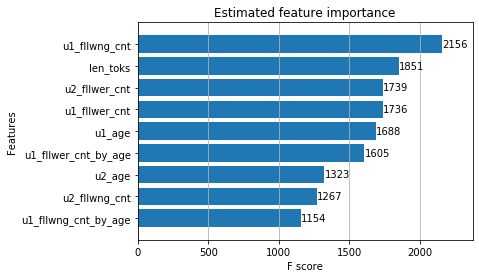

,0,1
6,u1_fllwng_cnt,2156
2,len_toks,1851
7,u2_fllwer_cnt,1739
1,u1_fllwer_cnt,1736
10,u1_age,1688
5,u1_fllwer_cnt_by_age,1605
9,u2_age,1323
0,u2_fllwng_cnt,1267
13,u1_fllwng_cnt_by_age,1154
21,twt_age,1084


Reply


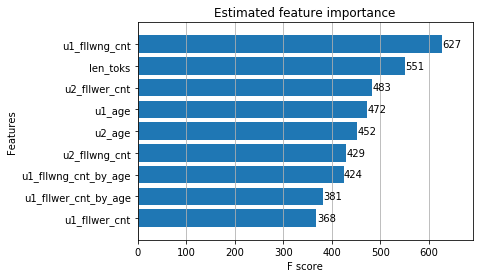

,0,1
6,u1_fllwng_cnt,627
7,len_toks,551
9,u2_fllwer_cnt,483
13,u1_age,472
1,u2_age,452
5,u2_fllwng_cnt,429
4,u1_fllwng_cnt_by_age,424
10,u1_fllwer_cnt_by_age,381
8,u1_fllwer_cnt,368
12,twt_age,335


Like


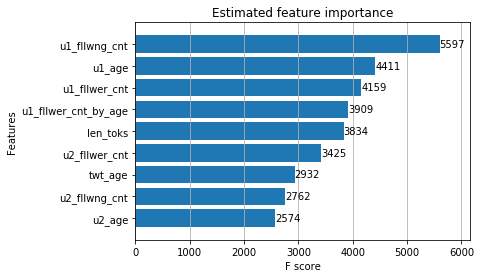

,0,1
13,u1_fllwng_cnt,5597
6,u1_age,4411
5,u1_fllwer_cnt,4159
4,u1_fllwer_cnt_by_age,3909
3,len_toks,3834
9,u2_fllwer_cnt,3425
14,twt_age,2932
11,u2_fllwng_cnt,2762
8,u2_age,2574
18,tm_hour,2460


RTwCmnt


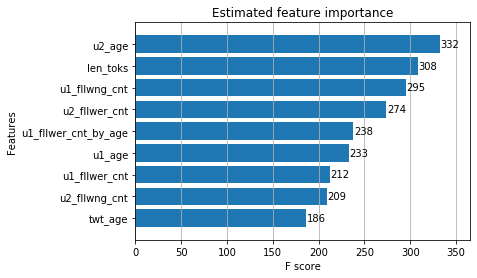

,0,1
1,u2_age,332
10,len_toks,308
13,u1_fllwng_cnt,295
0,u2_fllwer_cnt,274
3,u1_fllwer_cnt_by_age,238
12,u1_age,233
11,u1_fllwer_cnt,212
4,u2_fllwng_cnt,209
6,twt_age,186
2,u1_fllwng_cnt_by_age,178


In [16]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

## valid

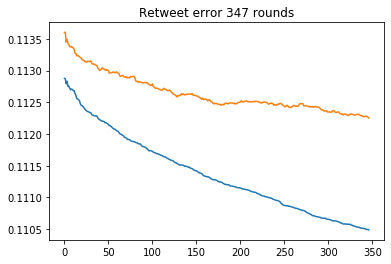

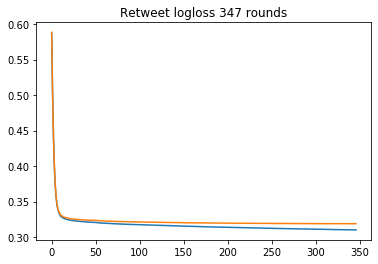

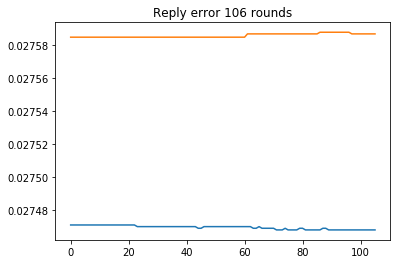

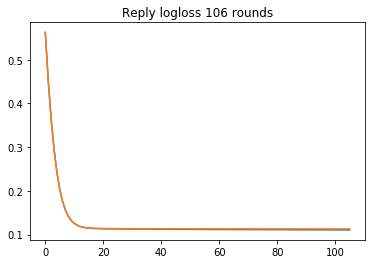

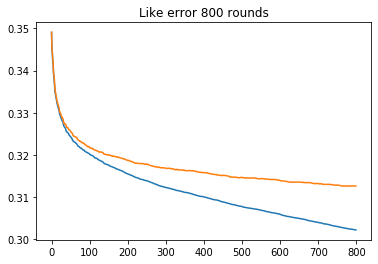

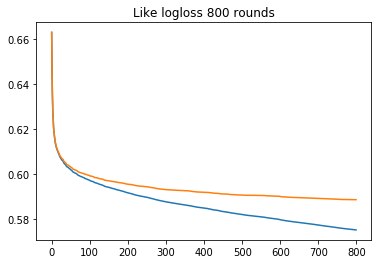

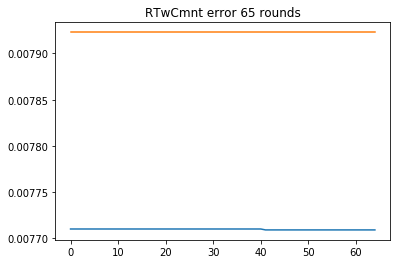

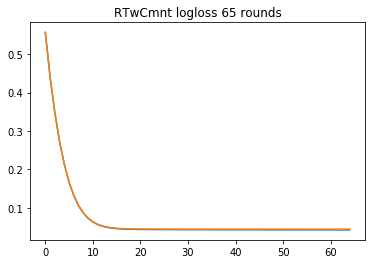

In [17]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()

In [18]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-20 20:26:35 Retweet
2020-03-20 20:26:50 Reply
2020-03-20 20:26:53 Like
2020-03-20 20:27:24 RTwCmnt


In [19]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7454 valid auc: 0.7246
train prauc: 0.3077 valid auc: 0.2753
train rce: 12.0445 valid rce: 9.9011
Reply
train rocauc: 0.7842 valid auc: 0.7678
train prauc: 0.1046 valid auc: 0.0877
train rce: 11.9556 valid rce: 10.3458
Like
train rocauc: 0.7606 valid auc: 0.7451
train prauc: 0.7103 valid auc: 0.6883
train rce: 16.1478 valid rce: 14.1636
RTwCmnt
train rocauc: 0.7227 valid auc: 0.6812
train prauc: 0.0286 valid auc: 0.0188
train rce: 5.9909 valid rce: 3.7722


In [20]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.307678,12.0445,0.104612,11.9556,0.71028,16.1478,0.0285847,5.99093
scrval,0.27528,9.90113,0.0876861,10.3458,0.688279,14.1636,0.0188077,3.77216


# infer

In [21]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 38s, sys: 8.57 s, total: 1min 46s
Wall time: 1min 47s


In [22]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 47 s, sys: 8.5 s, total: 55.5 s
Wall time: 55.5 s


In [23]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 20:31:17 Retweet
2020-03-20 20:31:58 Reply
2020-03-20 20:32:06 Like
2020-03-20 20:33:34 RTwCmnt
CPU times: user 36min 40s, sys: 13.9 s, total: 36min 54s
Wall time: 3min 1s


In [24]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [25]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 20:33:41 Retweet
2020-03-20 20:34:39 Reply
2020-03-20 20:35:38 Like
2020-03-20 20:36:34 RTwCmnt
CPU times: user 3min 44s, sys: 6.45 s, total: 3min 50s
Wall time: 3min 51s
